In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [4]:
df = pd.read_csv("/content/ETH-USD.csv")

In [5]:
# Kiểm tra dữ liệu
print(df.head())
print(df.info())

         Date        Open        High         Low       Close   Adj Close  \
0  2019-03-01  136.836243  138.995270  136.434784  136.443619  136.443619   
1  2019-03-02  136.350082  137.184799  132.436386  134.206955  134.206955   
2  2019-03-03  134.786118  135.849289  131.328857  132.249420  132.249420   
3  2019-03-04  132.157883  132.729141  125.402702  127.774124  127.774124   
4  2019-03-05  127.792953  138.229980  126.735298  137.822388  137.822388   

       Volume  
0  3756124824  
1  3747176425  
2  3454374053  
3  4008171341  
4  4764849990  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1828 non-null   object 
 1   Open       1828 non-null   float64
 2   High       1828 non-null   float64
 3   Low        1828 non-null   float64
 4   Close      1828 non-null   float64
 5   Adj Close  1828 non-null   float64
 6   Volume    

In [6]:
# Sử dụng cột 'Close' làm dữ liệu để dự đoán
df1 = df['Close'].values.reshape(-1, 1)

In [7]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [8]:
# Chia dữ liệu thành tập train và test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [9]:
# Kiểm tra kích thước của tập train và test
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1279
Test data size: 549


In [10]:
# Hàm tạo dataset từ chuỗi dữ liệu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# Tạo các tập X và Y từ dữ liệu train và test
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [12]:
# Định hình lại dữ liệu để phù hợp với đầu vào của TimesNet
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# Xây dựng mô hình TimesNet
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
19/19 [==============================] - 1s 9ms/step - loss: 0.0402
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 9/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 10/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 11/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 12/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 13/100
19/19 [=================

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


In [16]:
# Chuyển đổi giá trị về phạm vi gốc
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# Đánh giá mô hình
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mse = np.mean((y_test - test_predict)**2)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test MSE:', test_mse)

Train RMSE: 87.3108928596488
Test RMSE: 55.05536003859943
Test MAPE: 2.27686677569072
Test MSE: 3031.092668979811


In [18]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.41510422 0.41913304 0.41982664 0.41533296 0.40770371 0.41236624
 0.40823798 0.41305071 0.42040663 0.43711715 0.44307008 0.45360381
 0.4643719  0.4511462  0.47792886 0.47817396 0.47443969 0.47684049
 0.44963975 0.44484535 0.45731176 0.4692081  0.4485249  0.4501391
 0.44366341 0.4480859  0.43970537 0.4448184  0.4528225  0.47132356
 0.4676059  0.4583845  0.45984566 0.4511045  0.48242966 0.47579902
 0.46582865 0.46399407 0.46174069 0.47681183 0.47755809 0.44670091
 0.45909618 0.45901304 0.4532654  0.44927542 0.47270777 0.47521643
 0.52568486 0.53366439 0.51342419 0.52451382 0.50231726 0.51063859
 0.52687334 0.51425567 0.50120646 0.50598788 0.50175317 0.49841889
 0.46798451 0.45306573 0.45155041 0.4481788  0.45870516 0.45885113
 0.45658009 0.46931128 0.4751455  0.46196897 0.46649526 0.46739144
 0.4648391  0.46345822 0.46544542 0.48103901 0.4920022  0.49118573
 0.50556612 0.50848278 0.50983178 0.54185262 0.53846419 0.56733105
 0.57721657 0.57281636 0.56919648 0.588834   0.6025

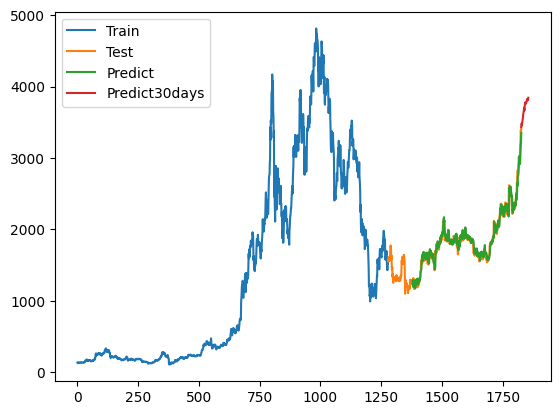

In [19]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_predict))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [20]:
x_input.shape

(1, 100, 1)

In [21]:
train_size_82 = int(0.8 * len(df1))
test_size_82 = len(df1) - train_size_82
train_data_82 = df1[:train_size_82]
test_data_82 = df1[train_size_82:train_size_82+test_size_82]

In [22]:
X_train_82, y_train_82 = create_dataset(train_data_82, time_step)
X_test_82, ytest_82 = create_dataset(test_data_82, time_step)

In [23]:
X_train_82 =X_train_82.reshape(X_train_82.shape[0],X_train_82.shape[1] , 1)
X_test_82 = X_test_82.reshape(X_test_82.shape[0],X_test_82.shape[1] , 1)

In [24]:
model.fit(X_train_82,y_train_82,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 15ms/step - loss: 3.4342e-04
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 3.3253e-04
Epoch 3/100
22/22 [==============================] - 0s 13ms/step - loss: 3.5526e-04
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 4.0400e-04
Epoch 5/100
22/22 [==============================] - 0s 15ms/step - loss: 3.9971e-04
Epoch 6/100
22/22 [==============================] - 0s 16ms/step - loss: 4.8881e-04
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 3.6322e-04
Epoch 8/100
22/22 [==============================] - 0s 15ms/step - loss: 3.3052e-04
Epoch 9/100
22/22 [==============================] - 0s 16ms/step - loss: 4.7779e-04
Epoch 10/100
22/22 [==============================] - 0s 14ms/step - loss: 5.2325e-04
Epoch 11/100
22/22 [==============================] - 0s 14ms/step - loss: 3.9108e-04
Epoch 12/100
22/22 [==============================] - 0s 15ms/s

In [25]:
train_predict_82 = model.predict(X_train_82)
test_predict_82 = model.predict(X_test_82)

9/9 [==============================] - 0s 3ms/step


In [26]:
train_predict_82 = scaler.inverse_transform(train_predict_82)
test_predict_82 = scaler.inverse_transform(test_predict_82)
y_train_82 = scaler.inverse_transform(y_train_82.reshape(-1, 1))
ytest_82 = scaler.inverse_transform(ytest_82.reshape(-1, 1))

In [27]:
train_82_rmse = np.sqrt(np.mean((train_predict_82 - y_train_82)**2))
test_82_rmse = np.sqrt(np.mean((test_predict_82 - ytest_82)**2))
test_82_mape = np.mean(np.abs((ytest_82 - test_predict_82) / ytest_82)) * 100
test_82_mse = np.mean((ytest_82 - test_predict_82)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 83.9503640053018
Test RMSE: 92.04931333604905
Test MAPE: 3.9774647313783245
Test MSE: 8473.076085638138


In [28]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_82[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.41510422 0.41913304 0.41982664 0.41533296 0.40770371 0.41236624
 0.40823798 0.41305071 0.42040663 0.43711715 0.44307008 0.45360381
 0.4643719  0.4511462  0.47792886 0.47817396 0.47443969 0.47684049
 0.44963975 0.44484535 0.45731176 0.4692081  0.4485249  0.4501391
 0.44366341 0.4480859  0.43970537 0.4448184  0.4528225  0.47132356
 0.4676059  0.4583845  0.45984566 0.4511045  0.48242966 0.47579902
 0.46582865 0.46399407 0.46174069 0.47681183 0.47755809 0.44670091
 0.45909618 0.45901304 0.4532654  0.44927542 0.47270777 0.47521643
 0.52568486 0.53366439 0.51342419 0.52451382 0.50231726 0.51063859
 0.52687334 0.51425567 0.50120646 0.50598788 0.50175317 0.49841889
 0.46798451 0.45306573 0.45155041 0.4481788  0.45870516 0.45885113
 0.45658009 0.46931128 0.4751455  0.46196897 0.46649526 0.46739144
 0.4648391  0.46345822 0.46544542 0.48103901 0.4920022  0.49118573
 0.50556612 0.50848278 0.50983178 0.54185262 0.53846419 0.56733105
 0.57721657 0.57281636 0.56919648 0.588834   0.6025

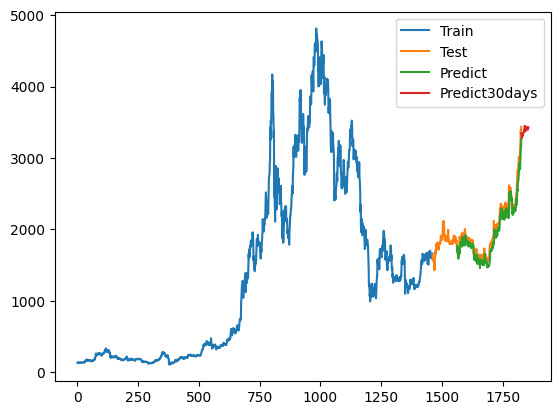

In [29]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_82, step=1)
plt.plot(scaler.inverse_transform(train_data_82))
test_data_index = pd.RangeIndex(start=train_size_82, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_82))
test_data_index = pd.RangeIndex(start=train_size_82+101, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,(test_predict_82))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [30]:
train_size_91 = int(0.9 * len(df1))
test_size_91 = len(df1) - train_size_91
train_data_91 = df1[:train_size_91]
test_data_91 = df1[train_size_91:train_size_91+test_size_91]

In [31]:
X_train_91, y_train_91 = create_dataset(train_data_91, time_step)
X_test_91, ytest_91 = create_dataset(test_data_91, time_step)

In [32]:
X_train_91 =X_train_91.reshape(X_train_91.shape[0],X_train_91.shape[1] , 1)
X_test_91 = X_test_91.reshape(X_test_91.shape[0],X_test_91.shape[1] , 1)

In [33]:
model.fit(X_train_91,y_train_91,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 0s 8ms/step - loss: 2.7538e-04
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 2.5440e-04
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 2.2751e-04
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 2.6122e-04
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 2.5270e-04
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 3.0421e-04
Epoch 7/100
25/25 [==============================] - 0s 14ms/step - loss: 2.4593e-04
Epoch 8/100
25/25 [==============================] - 0s 14ms/step - loss: 2.5156e-04
Epoch 9/100
25/25 [==============================] - 0s 14ms/step - loss: 2.6390e-04
Epoch 10/100
25/25 [==============================] - 0s 15ms/step - loss: 3.7187e-04
Epoch 11/100
25/25 [==============================] - 0s 14ms/step - loss: 2.2463e-04
Epoch 12/100
25/25 [==============================] - 0s 15ms/step 

In [34]:
train_predict_91 = model.predict(X_train_91)
test_predict_91 = model.predict(X_test_91)

3/3 [==============================] - 0s 6ms/step


In [35]:
train_predict_91 = scaler.inverse_transform(train_predict_91)
test_predict_91 = scaler.inverse_transform(test_predict_91)
y_train_91 = scaler.inverse_transform(y_train_91.reshape(-1, 1))
ytest_91 = scaler.inverse_transform(ytest_91.reshape(-1, 1))

In [36]:
train_91_rmse = np.sqrt(np.mean((train_predict_91 - y_train_91)**2))
test_91_rmse = np.sqrt(np.mean((test_predict_91 - ytest_91)**2))
test_91_mape = np.mean(np.abs((ytest_91 - test_predict_91) / ytest_91)) * 100
test_91_mse = np.mean((ytest_91 - test_predict_91)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 83.9503640053018
Test RMSE: 92.04931333604905
Test MAPE: 3.9774647313783245
Test MSE: 8473.076085638138


In [38]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_91[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.41510422 0.41913304 0.41982664 0.41533296 0.40770371 0.41236624
 0.40823798 0.41305071 0.42040663 0.43711715 0.44307008 0.45360381
 0.4643719  0.4511462  0.47792886 0.47817396 0.47443969 0.47684049
 0.44963975 0.44484535 0.45731176 0.4692081  0.4485249  0.4501391
 0.44366341 0.4480859  0.43970537 0.4448184  0.4528225  0.47132356
 0.4676059  0.4583845  0.45984566 0.4511045  0.48242966 0.47579902
 0.46582865 0.46399407 0.46174069 0.47681183 0.47755809 0.44670091
 0.45909618 0.45901304 0.4532654  0.44927542 0.47270777 0.47521643
 0.52568486 0.53366439 0.51342419 0.52451382 0.50231726 0.51063859
 0.52687334 0.51425567 0.50120646 0.50598788 0.50175317 0.49841889
 0.46798451 0.45306573 0.45155041 0.4481788  0.45870516 0.45885113
 0.45658009 0.46931128 0.4751455  0.46196897 0.46649526 0.46739144
 0.4648391  0.46345822 0.46544542 0.48103901 0.4920022  0.49118573
 0.50556612 0.50848278 0.50983178 0.54185262 0.53846419 0.56733105
 0.57721657 0.57281636 0.56919648 0.588834   0.6025

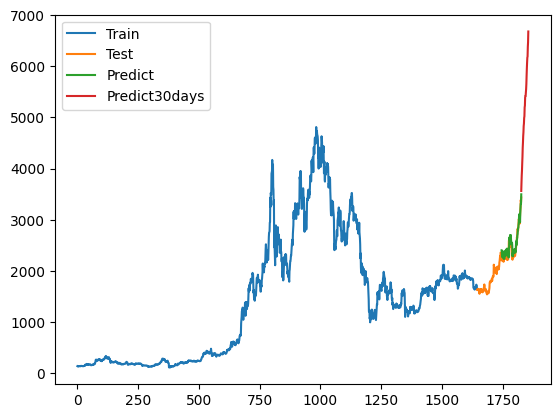

In [39]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_91, step=1)
plt.plot(scaler.inverse_transform(train_data_91))
test_data_index = pd.RangeIndex(start=train_size_91, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_91))
test_data_index = pd.RangeIndex(start=train_size_91+101, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,(test_predict_91))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()